# Bootstrap

In [1]:
# Reload the notebook if an external file is updated
%load_ext autoreload
%autoreload 2

import os
import sys

from pathlib import Path

path = (
    Path
    .cwd()
    .parent
    .parent
    .joinpath('warbler')
    .as_posix()
)

os.chdir(path)
sys.path.append(path)

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import scienceplots

from constant import PICKLE, SETTINGS, TUNING
from datatype.dataset import Dataset
from datatype.scorer import (
    CalinskiHarabaszScore, 
    DaviesBouldinIndex,
    PartitionCoefficient,
    PartitionEntropyCoefficient,
    Scorer,
    SilhouetteScore,
    SumOfSquaredErrors,
    XieBeniIndex
)
from datatype.settings import Settings
from fcmeans import FCM
from joblib import delayed, Parallel
from sklearn.metrics import silhouette_score
from sklearn.utils import resample
from tqdm import tqdm

In [ ]:
plt.style.use('science')

In [3]:
pd.set_option('display.max_colwidth', None)

In [4]:
dataset = Dataset('segment')
dataframe = dataset.load()

In [5]:
x = np.array(
    [
        dataframe.umap_x_2d,
        dataframe.umap_y_2d
    ]
).transpose()

In [6]:
metrics = [
    CalinskiHarabaszScore,
    DaviesBouldinIndex,
    PartitionCoefficient,
    PartitionEntropyCoefficient,
    SilhouetteScore,
    SumOfSquaredErrors,
    XieBeniIndex
]

In [7]:
def score(i):
    if i == 42:
        return None
    
    sample = resample(x, replace=True)

    fcm = FCM(
        m=2.9,
        max_iter=200,
        n_clusters=14,
        random_state=42
    )
    
    fcm.fit(sample)

    label = np.argmax(fcm.u, axis=1)

    scoring = {}
    
    for metric in metrics:
        metric = metric(estimator=fcm, x=x)
        scorer = Scorer(metric=metric)
        
        k = repr(scorer)
        v = scorer()
        
        scoring[k] = v

    return scoring

In [8]:
scoring = {
    repr(metric()): [] 
    for metric in metrics
}

In [9]:
iteration = 10

In [10]:
results = Parallel(n_jobs=5)(
    delayed(score)(i) 
    for i in tqdm(range(iteration), desc='Processing')
)

Processing: 100%|██████████████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.52s/it]


In [11]:
for local in results:
    if local is not None:
        for k, v in local.items():
            s = v[k]
            scoring[k].append(s)

In [12]:
score = pd.DataFrame.from_dict(scoring)

In [13]:
path = TUNING.joinpath('bootstrap.csv')
score.to_csv(path, index_label='id')

In [15]:
score.mean().to_frame()

,0
calinski_harabasz_score,18431.773645
davies_bouldin_index,0.831924
partition_coefficient,0.013787
partition_entropy_coefficient,0.223292
silhouette_score,0.400381
sum_of_squared_errors,2445.355570
xie_beni_index,0.034337


In [16]:
score.std().to_frame()

,0
calinski_harabasz_score,479.252046
davies_bouldin_index,0.039953
partition_coefficient,0.000107
partition_entropy_coefficient,0.000502
silhouette_score,0.010533
sum_of_squared_errors,12.255334
xie_beni_index,0.021317


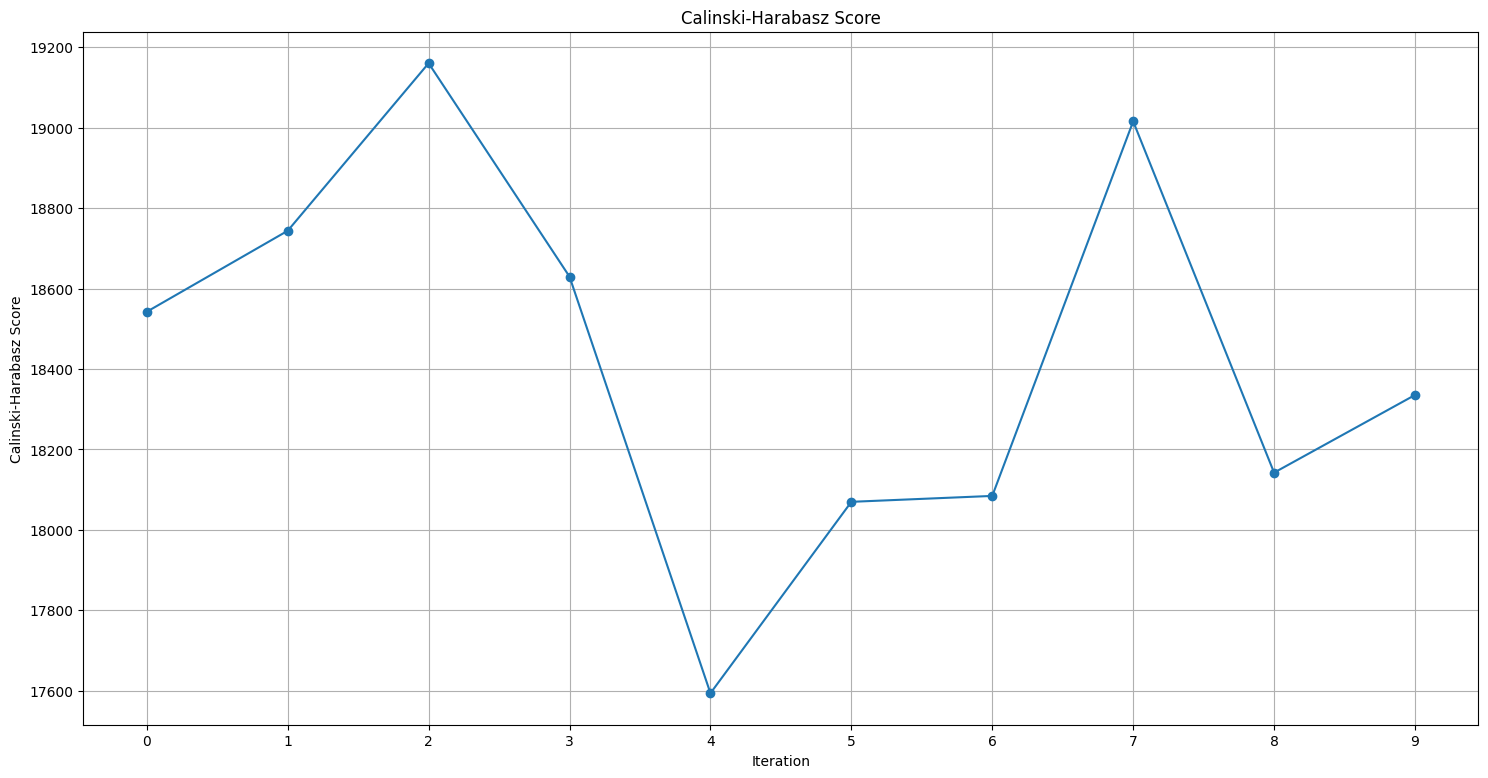

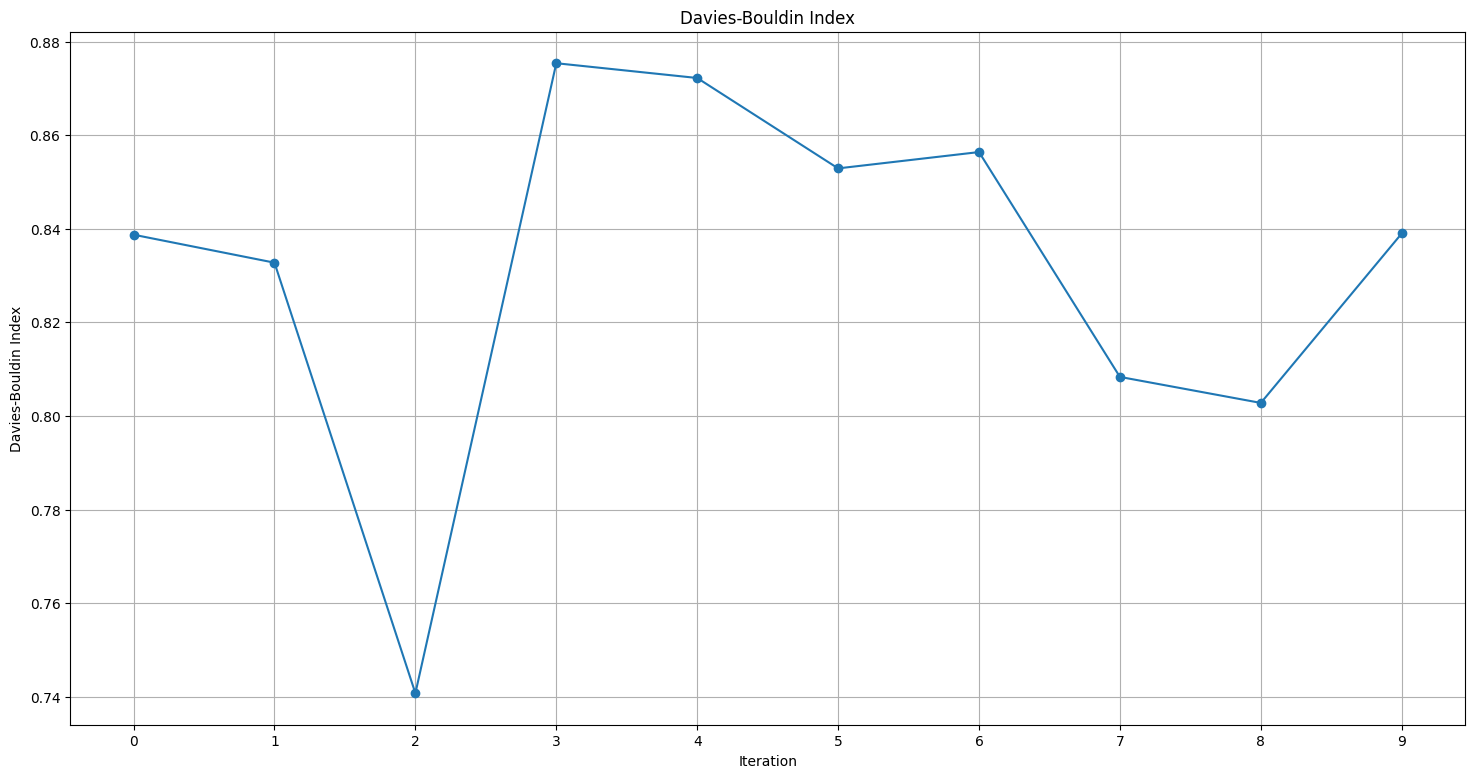

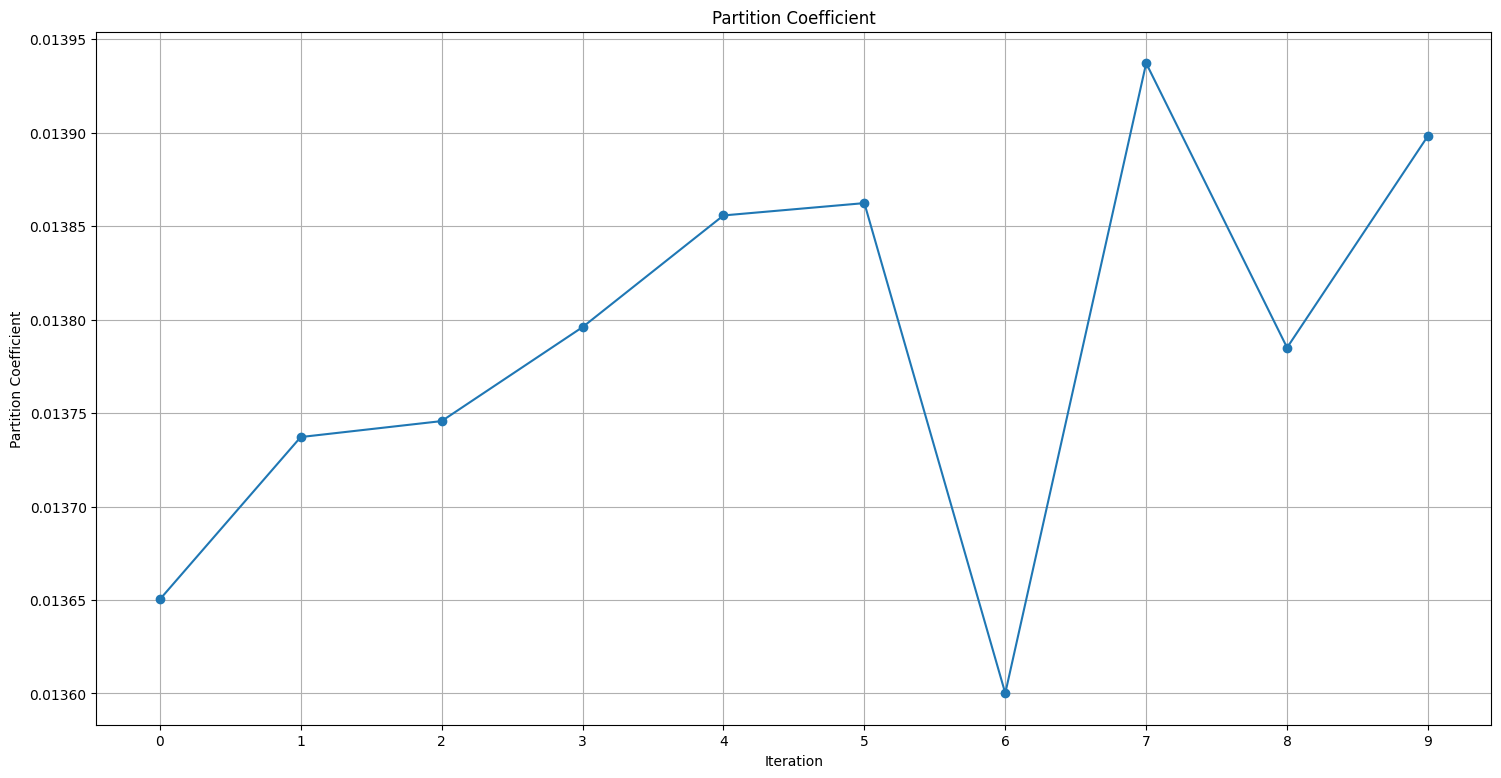

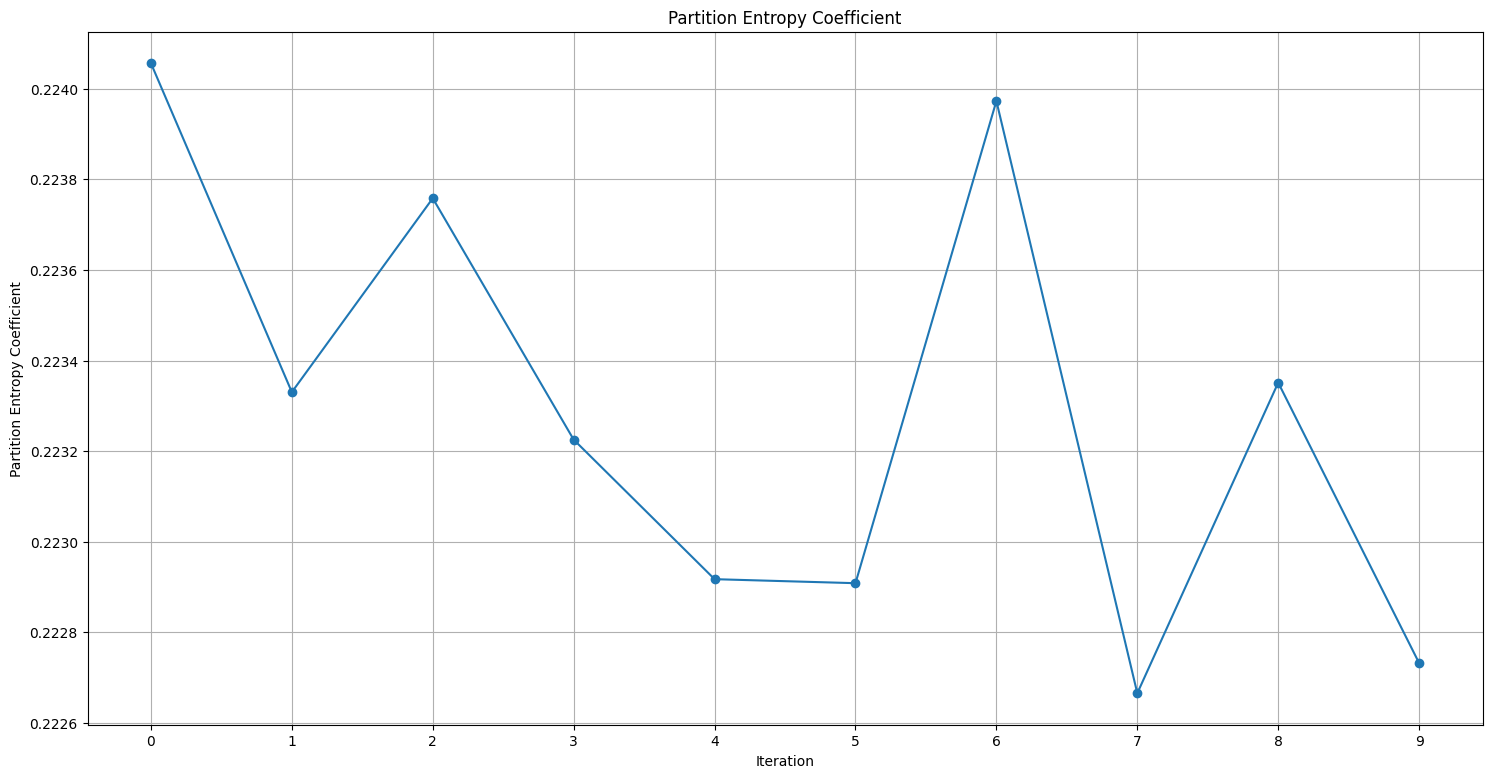

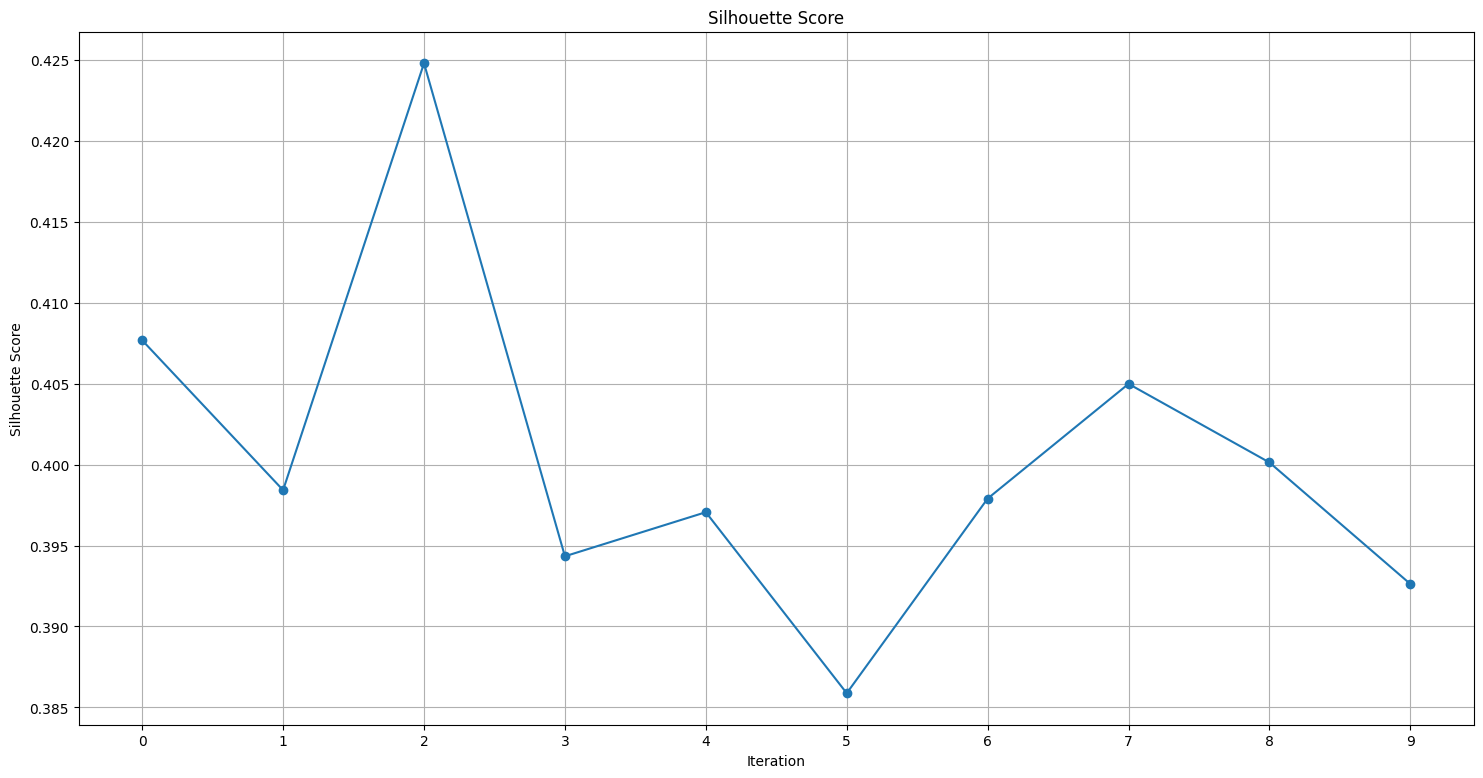

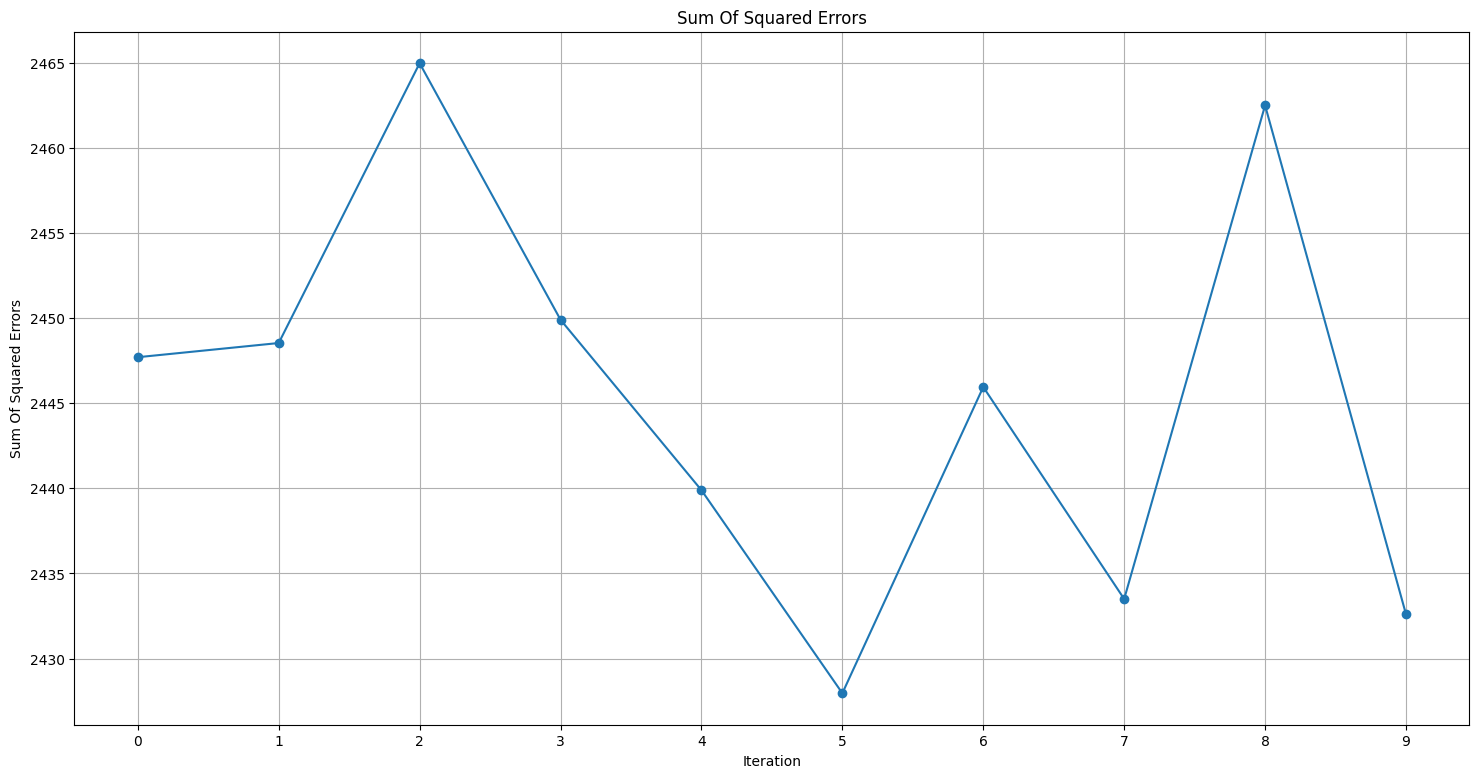

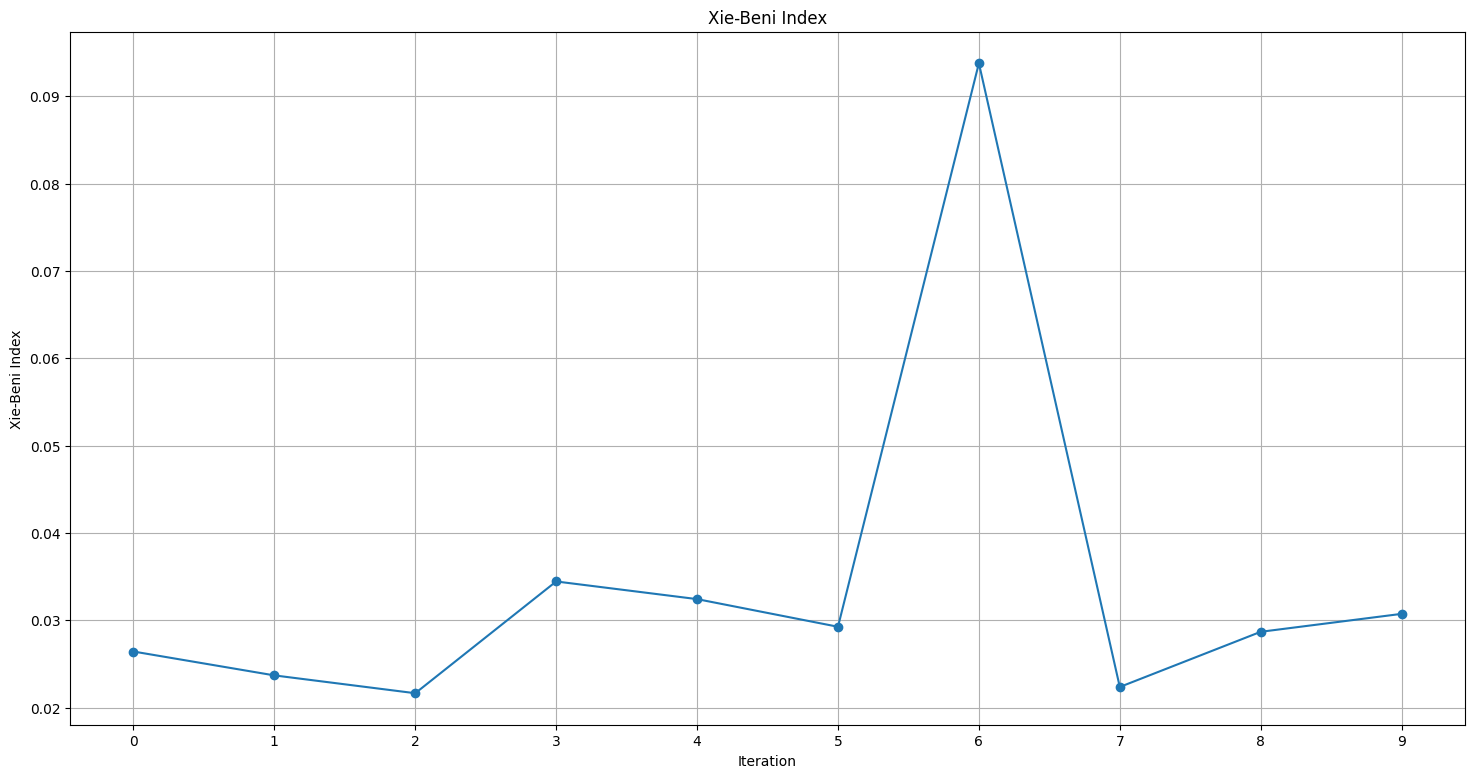

In [17]:
figsize = (18, 9)

for metric in metrics:
    instance = metric()
    
    column = repr(instance)
    title, ylabel = str(instance), str(instance)

    s = score[column].tolist()

    plt.figure(figsize=figsize)
    
    plt.plot(s, marker='o')
    
    plt.xlabel('Iteration')
    plt.ylabel(ylabel)
    
    ax = plt.gca()
    
    locator = ticker.MaxNLocator(integer=True)
    ax.xaxis.set_major_locator(locator)
    
    plt.title(title)

    plt.grid(visible=True)
    plt.show()
    plt.close()